# NetColoc analysis of rare variants in Autism spectrum disorder (ASD) and Congenital Heart Disease (CHD)

Example of NetColoc workflow on genes associated with rare exome variants in ASD and CHD

**Some background:**

Here we introduce NetColoc, a tool which evaluates the extent to which two gene sets are related in network space, i.e. the extent to which they are colocalized in a molecular interaction network, and interrogates the underlying biological pathways and processes using multiscale community detection. This framework may be applied to any number of scenarios in which gene sets have been associated with a phenotype or condition, including rare and common variants within the same disease, genes associated with two comorbid diseases, genetically correlated GWAS phenotypes, GWAS across two different species, or gene expression changes after treatment with two different drugs, to name a few. NetColoc relies on a dual network propagation approach to identify the region of network space which is significantly proximal to both input gene sets, and as such is highly effective for small to medium input gene sets.



# _Obtain input gene sets and interactome_

## 1. Load required packages

In [1]:
# load required packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd
import re
import random

from IPython.display import display

import getpass
import ndex2

import json
import cdapsutil

from gprofiler import GProfiler
gp = GProfiler("MyToolName/0.1")

from scipy.stats import hypergeom
from scipy.stats import norm

# latex rendering of text in graphs
import matplotlib as mpl
mpl.rc('text', usetex = False)
mpl.rc('font', family = 'serif')

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

sns.set(font_scale=1.4)

sns.set_style('white')

sns.set_style("ticks", {"xtick.major.size": 15, "ytick.major.size": 15})
plt.rcParams['svg.fonttype'] = 'none'

from datetime import datetime
import sys
%matplotlib inline

In [2]:
# verify DDOT was installed
import ddot

from netcoloc import netprop_zscore, netprop, network_colocalization, validation


/Users/karissabarthelson/miniconda3/envs/netcoloc/lib/python3.9/site-packages/netcoloc/validation.py:20: UserWarning: Import of ddot failed. NetColoc will not work properly: + cannot import name 'Ontology' from 'ddot' (unknown location)
  warnings.warn('Import of ddot failed. NetColoc will not work properly: + ' + str(ie))


## 2. Select two gene sets of interest. Load gene sets from text files into python.


Identify two gene sets of interest. Gene sets should come from experimental data (not manual curation) to avoid bias. 

**Usage Note**: gene sets should be < 500 genes (propagation algorithm breaks down if seeded with larger sets). If your gene set is larger, only use the top 500 as seeds to the network propagation.



In [9]:
# set names of geneset 1 and geneset 2
# ------ customize this section based on your gene sets and how they should be labeled -------
d1_name='childhood'
d2_name='adult'

In [10]:
# ------ customize this section based your input genesets -------

# load rare variants
D1_df = pd.read_csv('genesets/childhooddementiagenes.csv')
D1_df.index = D1_df['GENE']
print('Number of '+d1_name+' genes:', len(D1_df))
D1_genes = D1_df.index.tolist() # define rare variant genes to seed network propagation
print("First 5 genes:", D1_genes[0:5])

Number of childhood genes: 235
First 5 genes: ['SGSH', 'NAGLU', 'HGSNAT', 'GNS', 'MTTP']


In [17]:
# ------ customize this section based your input genesets -------

# load D2 rare variant genes from Jin et al 2017; PMID: 28991257
D2_df = pd.read_csv('genesets/Adult_Onset.txt',sep='\t')
#print(D2_df)
D2_genes = D2_df["GENE"].tolist()
#print(D2_genes)
print('Number of '+d2_name+' genes:',len(D2_genes))
print('First 5 genes:', D2_genes[0:5])

Number of adult genes: 235
First 5 genes: ['ABCA1', 'ABCA7', 'ABI3', 'ACE', 'ADAM17']


In [18]:
# Output the overlap between the two gene sets
print('Number of '+d1_name+' and '+d2_name+' genes overlapping:', len(np.intersect1d(D1_genes,D2_genes)))

# Create a dictionary for each geneset
seed_dict = {d1_name:D1_genes,d2_name:D2_genes}


Number of childhood and adult genes overlapping: 15


## 3. Select gene interaction network to use for the analysis.

Identify network UUID on NDEx (ndexbio.org) and use this to import to this Jupyter notebook. We recommend using PCNet as a starting point, but a user may want to switch to “STRING high confidence” if using a machine with low memory (< 8GB RAM).


In [19]:
interactome_uuid='4de852d9-9908-11e9-bcaf-0ac135e8bacf' # for PCNet
# interactome_uuid='275bd84e-3d18-11e8-a935-0ac135e8bacf' # for STRING high confidence
ndex_server='public.ndexbio.org'
ndex_user=None
ndex_password=None
G_int = ndex2.create_nice_cx_from_server(
            ndex_server, 
            username=ndex_user, 
            password=ndex_password, 
            uuid=interactome_uuid
        ).to_networkx()
nodes = list(G_int.nodes)

# remove self edges from network
G_int.remove_edges_from(nx.selfloop_edges(G_int))

# print out the numbers of nodes and edges in the interatome for diagnostic purposes:
print('Number of nodes:', len(G_int.nodes))
print('\nNumber of edges:', len(G_int.edges))

Number of nodes: 18820

Number of edges: 2693109


In [20]:
int_nodes = list(G_int.nodes)

# _Identify network colocalized gene network_

## 4. Precalculate matrices needed for propagation. This step should take a few minutes (more for larger/denser networks) 

A benchmarking analysis demonstrates that the runtime required scales with the number of edges (w’) and the number of nodes (w’’). NetColoc includes functionality for saving and loading these matrices, by setting the XXX parameter, which can be useful if running multiple analyses. The diffusion parameter, which controls the rate of propagation through the network, may be set in this step. In practice, we have found that results are not dependent on the choice of this parameter, and recommend using the default value of 0.5.

Background on network propagation: https://www.nature.com/articles/nrg.2017.38.pdf?origin=ppub


In [21]:
# pre-calculate matrices used for network propagation. this step takes a few minutes, more for denser interactomes
print('\ncalculating w_prime')
w_prime = netprop.get_normalized_adjacency_matrix(G_int, conserve_heat=True)

print('\ncalculating w_double_prime')
w_double_prime = netprop.get_individual_heats_matrix(w_prime, .5)

# w_double_prime can be saved to the file netcoloc_w_double_prime.npy
# in current working directory with the following call:
#
# np.save('netcoloc_w_double_prime.npy', w_double_prime)

# and reloaded later with:
# w_double_prime = np.load('netcoloc_w_double_prime.npy')
#
# NOTE: Saving w_double_prime results in a several gigabyte file and
#       takes a minute or more to save and load



calculating w_prime

calculating w_double_prime


## 5. Subset seed genes to those found in the selected network. 

Only genes contained in the interaction network will be retained for downstream analysis. 


In [22]:
# subset seed genes to those found in interactome
print("Number of D1 genes:", len(D1_genes))
D1_genes = list(np.intersect1d(D1_genes,int_nodes))
print("Number of D1 genes in interactome:", len(D1_genes))

print("Number of D2 genes:", len(D2_genes))
D2_genes = list(np.intersect1d(D2_genes,int_nodes))
print("Number of D2 genes in interactome:", len(D2_genes))


Number of D1 genes: 235
Number of D1 genes in interactome: 196
Number of D2 genes: 235
Number of D2 genes in interactome: 226


## 6. Compute network proximity scores from both seed gene sets independently.

The network proximity scores include a correction for the degree distribution of the input gene sets. The runtime required for computing the network proximity scores increases linearly with the number of nodes in the underlying interaction network and with the size of the input gene list

In [23]:
# D1 network propagation
print('\nCalculating D1 z-scores: ')
z_D1, Fnew_D1, Fnew_rand_D1 = netprop_zscore.calculate_heat_zscores(w_double_prime, int_nodes, 
                                                                    dict(G_int.degree), 
                                                                    D1_genes, num_reps=1000,
                                                                    minimum_bin_size=100)

z_D1 = pd.DataFrame({'z':z_D1})

z_D1.sort_values('z',ascending=False).head()


Calculating D1 z-scores: 


  0%|          | 0/1000 [00:00<?, ?it/s]

,z
DLAT,23.819753
EIF2B1,23.796715
LRPPRC,23.454761
PDHB,23.177739
DLD,22.877058


In [24]:
# D2 network propagation
print('\nCalculating D2 z-scores: ')
z_D2, Fnew_D2, Fnew_rand_D2 = netprop_zscore.calculate_heat_zscores(w_double_prime, int_nodes, 
                                                                    dict(G_int.degree), 
                                                                    D2_genes, num_reps=1000,
                                                                    minimum_bin_size=100)

z_D2 = pd.DataFrame({'z':z_D2})
z_D2.sort_values('z',ascending=False).head()


Calculating D2 z-scores: 


  0%|          | 0/1000 [00:00<?, ?it/s]

,z
HNRNPA2B1,28.059209
TARDBP,27.875419
MATR3,26.600785
NMD3,24.855657
SEC61G,24.695853


## 7. Build NetColoc subnetwork and evaluate for significant network colocalization. 

To build the NetColoc subnetwork we take the product of the two proximity vectors as follows:

$z_{coloc}=z_1 \times z_2$  

We then select genes for which $z_{coloc}$ is greater than a threshold ($z_{coloc}>3$ here, but can be set by the user), and the network proximity scores were individually larger than a nominal threshold ($z_1>1.5$, and $z_2>1.5$ here, but can be set by the user). The subnetwork comprising the genes and interactions meeting these criteria make up the network colocalization subnetwork. 

The authors have found that the default threshold values work well in practice, to find the set of genes which is proximal to both seed gene sets. Tuning them higher will lead to fewer false positives, but more false negatives. Similarly, tuning them lower will lead to more false positives, but fewer false negatives. Either may be warranted given the specifics of an experiment. 

The researcher may conduct a sensitivity analysis of these thresholds to select to find a balance between higher NetColoc enrichment score, but smaller network, and lower NetColoc enrichment score, but larger network. The function ‘network_colocalization.calculate_network_enrichment’ is provided to enable such a sensitivity analysis. In this function, the network colocalization score is computed for the gene set pair, based on the observed network overlap and expected network overlap, over a range of z-score thresholds. 

If gene sets are significantly colocalized, proceed with analysis. Gene sets which are not significantly colocalized in the network have no evidence for shared underlying pathways, and thus proceeding with analysis of the network intersection in this case is not likely to return meaningful results.



In [25]:
zlist = [2,3,4,5,9,12]
z12list = [1,1.5,2]
netcoloc_enrichment_df = network_colocalization.calculate_network_enrichment(z_D1,z_D2,
                                                                             zthresh_list = zlist,
                                                                             z12thresh_list=z12list,
                                                                             verbose=True)
netcoloc_enrichment_df.head()

z = 2
z12 = 1
size of network intersection = 758
observed size/ expected size = 1.3198676649834582
p = 2.262477407939971e-23
z = 2
z12 = 1.5
size of network intersection = 400
observed size/ expected size = 1.3341338136215062
p = 1.2487509632032646e-11
z = 2
z12 = 2
size of network intersection = 202
observed size/ expected size = 1.6425435030086193
p = 1.1182429386799558e-23
z = 3
z12 = 1
size of network intersection = 560
observed size/ expected size = 1.3275804845668768
p = 5.053704825924327e-17
z = 3
z12 = 1.5
size of network intersection = 383
observed size/ expected size = 1.3768558794981485
p = 8.591487042558053e-17
z = 3
z12 = 2
size of network intersection = 202
observed size/ expected size = 1.6260162601626016
p = 5.399999404869976e-14
z = 4
z12 = 1
size of network intersection = 406
observed size/ expected size = 1.3497789155224575
p = 2.6467269123816482e-17
z = 4
z12 = 1.5
size of network intersection = 313
observed size/ expected size = 1.3793407368235502
p = 2.14582467166

,z_comb,z_12,observed_overlap,expected_overlap_mean,expected_overlap_std,empirical_p,obs_exp
0,2,1.0,758,574.30,18.571214,2.262477e-23,1.319868
1,2,1.5,400,299.82,15.011582,1.248751e-11,1.334134
2,2,2.0,202,122.98,7.932188,1.118243e-23,1.642544
3,3,1.0,560,421.82,16.641142,5.053705e-17,1.327580
4,3,1.5,383,278.17,12.721678,8.591487e-17,1.376856


### Select z thresholds, and plot the sizes of the observed and expected NetColoc subnetworks.

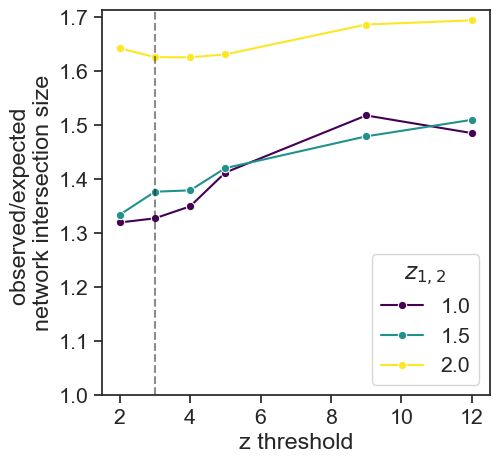

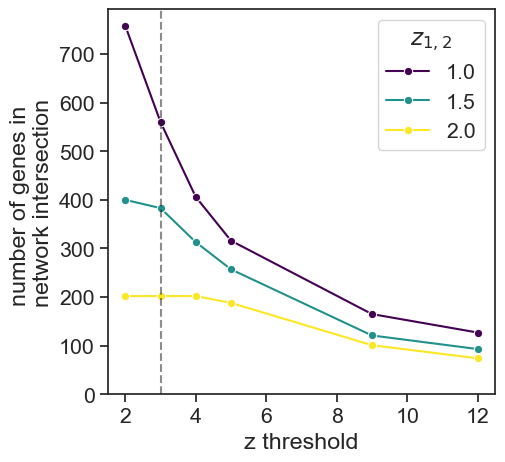

In [26]:
plt.figure(figsize=(5,5))
sns.lineplot(x='z_comb',y='obs_exp',data=netcoloc_enrichment_df,hue='z_12',style='z_12',
            markers=['o','o','o'],dashes=False,palette='viridis')
ylim_max=plt.gca().get_ylim()[1]
plt.ylim([1,ylim_max])
plt.plot([3,3],[1,ylim_max],'k--',alpha=.5)

plt.xlabel('z threshold')
plt.ylabel('observed/expected \nnetwork intersection size')
plt.legend(title="$z_{1,2}$")

plt.figure(figsize=(5,5))
sns.lineplot(x='z_comb',y='observed_overlap',data=netcoloc_enrichment_df,hue='z_12',style='z_12',
            markers=['o','o','o'],dashes=False,palette='viridis')

ylim_max=plt.gca().get_ylim()[1]
plt.ylim([0,ylim_max])
plt.plot([3,3],[0,ylim_max],'k--',alpha=.5)

plt.xlabel('z threshold')
plt.ylabel('number of genes in \nnetwork intersection')
plt.legend(title="$z_{1,2}$")

(-1.0, 2.0)

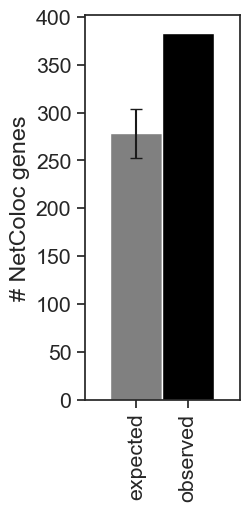

In [27]:
# ----------- select thresholds for NetColoc -----------------
zthresh=3 # default = 3
z12_thresh=1.5 # default = 1.5
# ------------------------------------------------------------

focal_netcoloc_enrichment = netcoloc_enrichment_df[(netcoloc_enrichment_df['z_comb']==zthresh) & \
                                                   (netcoloc_enrichment_df['z_12']==z12_thresh)].iloc[0]

# plot the observed and expected overlaps
plt.figure(figsize=(2,5))
plt.bar([0,1],[focal_netcoloc_enrichment['expected_overlap_mean'],
               focal_netcoloc_enrichment['observed_overlap']],color=['gray','black'],width=1)
plt.errorbar([0],[focal_netcoloc_enrichment['expected_overlap_mean']],
             [2*focal_netcoloc_enrichment['expected_overlap_std']],color='k',capsize=4)
plt.ylabel('# NetColoc genes')
plt.xticks([0,1],['expected','observed'],rotation='vertical')
plt.xlim([-1,2])

### Build network colocalization subnetwork based on selected thresholds

In [28]:
# select the genes in the network intersection, make a subgraph

G_overlap = network_colocalization.calculate_network_overlap_subgraph(G_int,z_D1['z'],z_D2['z'],z_score_threshold=zthresh,
                                                                     z1_threshold=z12_thresh,z2_threshold=z12_thresh)
print("Nodes in overlap subgraph:", len(G_overlap.nodes()))
print("Edges in overlap subgraph:", len(G_overlap.edges()))

Nodes in overlap subgraph: 383
Edges in overlap subgraph: 5720


## 8. Transform NetColoc subnetwork edges to cosine similarities (OPTIONAL)

Transform NetColoc subnetwork edges to cosine similarities, with the function ‘network_colocalization.transform_edges’. The cosine similarity score between two genes represents the extent to which those genes have similar interactors. In practice, the cosine similarity transformed score helps to visually reveal the underlying clustering structure present in a network. 



In [17]:
G_cosSim=network_colocalization.transform_edges(G_overlap,method='cosine_sim',edge_weight_threshold=0.95)

# _Compute network colocalized systems map_

## 9. Convert network colocalization subnetwork to form used in community detection module

In [29]:
# compile dataframe of metadata for overlapping nodes
node_df = pd.DataFrame(index=list(G_overlap.nodes))
node_df = node_df.assign(d1_seeds=0, d2_seeds=0, d1_name=d1_name, d2_name=d2_name)
node_df.loc[list(np.intersect1d(seed_dict[d1_name],node_df.index.tolist())), 'd1_seeds']=1
node_df.loc[list(np.intersect1d(seed_dict[d2_name],node_df.index.tolist())), 'd2_seeds']=1
node_df['z_d1']=z_D1.loc[list(G_overlap.nodes)]['z']
node_df['z_d2']=z_D2.loc[list(G_overlap.nodes)]['z']
node_df['z_both']=node_df['z_d1']*node_df['z_d2']
node_df['sum_seeds']=node_df['d1_seeds']+node_df['d2_seeds']

node_df = node_df.sort_values('z_both',ascending=False)
node_df.head(15)

,d1_seeds,d2_seeds,d1_name,d2_name,z_d1,z_d2,z_both,sum_seeds
UBTF,1,1,childhood,adult,20.668777,21.706429,448.645343,2
GCH1,1,1,childhood,adult,18.577811,20.121576,373.814828,2
SPG11,1,1,childhood,adult,18.274631,19.822936,362.256829,2
CSF1R,1,1,childhood,adult,17.902270,16.831756,301.326653,2
SQSTM1,1,1,childhood,adult,16.417785,16.845935,276.572928,2
SYNJ1,1,1,childhood,adult,15.609557,15.939803,248.813271,2
PLA2G6,1,1,childhood,adult,14.412884,14.434002,208.035597,2
POLG,1,1,childhood,adult,12.862304,14.773280,190.018427,2
MCCC1,1,1,childhood,adult,14.377555,13.065463,187.849417,2
ATP13A2,1,1,childhood,adult,13.627363,12.416800,169.208247,2


## 10. Run community detection on NetColoc subnetwork (recommend HiDef).

Documentation for CDAPS utils to build multiscale systems map in notebook

https://cdapsutil.readthedocs.io/en/latest/quicktutorial.html#example  
https://cdapsutil.readthedocs.io/en/latest/cdapsutil.html#community-detection  

In [126]:
print("Nodes in overlap subgraph:", len(G_overlap.nodes()))
print("Edges in overlap subgraph:", len(G_overlap.edges()))
# Create cx format of overlap subgraph
G_overlap_cx = ndex2.create_nice_cx_from_networkx(G_overlap)
G_overlap_cx.set_name(d1_name+'_'+d2_name+'_NetColoc_subgraph') 
for node_id, node in G_overlap_cx.get_nodes():
    data = node_df.loc[node['n']]
    for row, value in data.items():
        if row == 'd1_seeds' or row == 'd2_seeds' or row=='sum_seeds':
            data_type = 'double'
        elif row=='d1_name' or row=='d2_name':
            data_type='string'
        else:
            data_type = 'double'
        G_overlap_cx.set_node_attribute(node_id, row, value, type=data_type)

cd = cdapsutil.CommunityDetection()

# Run HiDeF on CDAPS REST service
G_hier = cd.run_community_detection(G_overlap_cx, algorithm='hidefv1.1beta',arguments={'--maxres':'20'})

Nodes in overlap subgraph: 383
Edges in overlap subgraph: 5720


In [127]:
# Print information about hierarchy
print('Hierarchy name: ' + str(G_hier.get_name()))
print('# nodes: ' + str(len(G_hier.get_nodes())))
print('# edges: ' + str(len(G_hier.get_edges())))

Hierarchy name: hidefv1.1beta_(none)_childhood_adult_NetColoc_subgraph
# nodes: 60
# edges: 59


In [21]:
# sr = cdapsutil.ServiceRunner()
# sr.get_algorithms() # this will print out available options for each algorithm

## 11. Convert the NetColoc hierarchy to networkx format, and write out features of the hierarchy to a pandas dataframe, for easier access in Python.


In [128]:
G_hier = G_hier.to_networkx(mode='default')
G_hier

nodes = G_hier.nodes()

# print the number of nodes and edges in the hierarchy for diagnostic purposes
print('Number of nodes:', len(G_hier.nodes()))

print('\nNumber of edges:', len(G_hier.edges()))




Number of nodes: 60

Number of edges: 59


In [33]:
# add node attributes to dataframe for easier access
hier_df = pd.DataFrame.from_dict(dict(G_hier.nodes(data=True)), orient='index')
hier_df['system_ID']=hier_df.index.tolist()
# some columns are not the right type
hier_df['CD_MemberList_Size']=[int(x) for x in hier_df['CD_MemberList_Size'].tolist()]
hier_df['HiDeF_persistence']=[int(x) for x in hier_df['HiDeF_persistence'].tolist()]
hier_df.head()

,CD_MemberList,CD_MemberList_Size,CD_Labeled,CD_MemberList_LogSize,CD_CommunityName,CD_AnnotatedMembers,CD_AnnotatedMembers_Size,CD_AnnotatedMembers_Overlap,CD_AnnotatedMembers_Pvalue,HiDeF_persistence,represents,name,system_ID
0,SLC25A35 AC138894.1 B3GAT3 AKR1B10 RHBDF2 SNX4...,369,False,8.527,,,0,0.0,0.0,123,C382,C382,0
1,SLC31A2 IL34 LGMN LITAF MINDY1 FUCA1 IRF2 CHI3...,69,False,6.109,,,0,0.0,0.0,28,C384,C384,1
2,SLC25A35 POLG SLC25A5 AGPS MTERF2 SLC25A6 ALDH...,40,False,5.322,,,0,0.0,0.0,8,C386,C386,2
3,AC138894.1 KCND2 PSEN2 ATP6V1B1 KCNIP3 SNAP25 ...,13,False,3.7,,,0,0.0,0.0,15,C389,C389,3
4,SGMS2 GALC SGMS1 ASAH1 GTF2H2C_2 ASAH2B GTF2H2...,12,False,3.585,,,0,0.0,0.0,25,C390,C390,4


## 12. Remove systems with no seed genes (OPTIONAL)

In [129]:
hier_df.index=hier_df['name']
hier_df.head()

num_d1_seeds, num_d2_seeds, num_both_seeds = [],[],[]
frac_d1_seeds, frac_d2_seeds, frac_both_seeds=[],[],[]

systems_keep = []
for c in hier_df.index.tolist():
    system_genes = hier_df['CD_MemberList'].loc[c].split(' ')
    d1_temp = list(np.intersect1d(system_genes,seed_dict[d1_name]))
    d2_temp = list(np.intersect1d(system_genes,seed_dict[d2_name]))
    num_d1_temp = len(d1_temp)
    num_d2_temp = len(d2_temp)
    if (num_d1_temp+num_d2_temp)>0: # keep the system if it has at least 1 seed gene
        systems_keep.append(c)
        num_both_temp = len(np.intersect1d(d1_temp,d2_temp))
        num_both_seeds.append(num_both_temp)
        num_d1_seeds.append(num_d1_temp-num_both_temp)
        num_d2_seeds.append(num_d2_temp-num_both_temp)
        
        frac_both_seeds.append(num_both_temp/float(len(system_genes)))
        frac_d1_seeds.append((num_d1_temp-num_both_temp)/float(len(system_genes)))
        frac_d2_seeds.append((num_d2_temp-num_both_temp)/float(len(system_genes)))

        
frac_no_seeds = np.subtract(1.0,np.array([frac_d1_seeds,frac_d2_seeds,frac_both_seeds]).sum(axis=0))

hier_df = hier_df.loc[systems_keep]
hier_df['num_d1_seeds']=num_d1_seeds
hier_df['num_d2_seeds']=num_d2_seeds
hier_df['num_both_seeds']=num_d2_seeds
hier_df['frac_d1_seeds']=frac_d1_seeds
hier_df['frac_d2_seeds']=frac_d2_seeds
hier_df['frac_both_seeds']=frac_both_seeds
hier_df['frac_no_seeds']=frac_no_seeds
print("Number of nodes with seed genes:", len(hier_df))

hier_df.head()
    

Number of nodes with seed genes: 50


,CD_MemberList,CD_MemberList_Size,CD_Labeled,CD_MemberList_LogSize,CD_CommunityName,CD_AnnotatedMembers,CD_AnnotatedMembers_Size,CD_AnnotatedMembers_Overlap,CD_AnnotatedMembers_Pvalue,HiDeF_persistence,represents,name,system_ID,num_d1_seeds,num_d2_seeds,num_both_seeds,frac_d1_seeds,frac_d2_seeds,frac_both_seeds,frac_no_seeds
name,,,,,,,,,,,,,,,,,,,,
C382,SLC25A35 AC138894.1 B3GAT3 AKR1B10 RHBDF2 SNX4...,369,False,8.527,,,0,0.0,0.0,123,C382,C382,0,29,38,38,0.078591,0.102981,0.037940,0.780488
C384,SLC31A2 IL34 LGMN LITAF MINDY1 FUCA1 IRF2 CHI3...,69,False,6.109,,,0,0.0,0.0,28,C384,C384,1,14,7,7,0.202899,0.101449,0.043478,0.652174
C386,SLC25A35 POLG SLC25A5 AGPS MTERF2 SLC25A6 ALDH...,40,False,5.322,,,0,0.0,0.0,8,C386,C386,2,0,5,5,0.000000,0.125000,0.050000,0.825000
C389,AC138894.1 KCND2 PSEN2 ATP6V1B1 KCNIP3 SNAP25 ...,13,False,3.7,,,0,0.0,0.0,15,C389,C389,3,3,2,2,0.230769,0.153846,0.000000,0.615385
C390,SGMS2 GALC SGMS1 ASAH1 GTF2H2C_2 ASAH2B GTF2H2...,12,False,3.585,,,0,0.0,0.0,25,C390,C390,4,1,0,0,0.083333,0.000000,0.166667,0.750000


In [130]:
# prune G_hier--> only keep systems with at least one seed gene

nkeep=[]
for n in list(G_hier.nodes()):
    if G_hier.nodes(data=True)[n]['name'] in systems_keep:
        nkeep.append(n)
        

G_hier = nx.subgraph(G_hier, nkeep)
print("Number of nodes with seed genes:", len(G_hier.nodes()))
print("Number of edges remaining:", len(G_hier.edges()))

Number of nodes with seed genes: 50
Number of edges remaining: 49


## 13. Sneak peek of hierarchy visualization (OPTIONAL)

In [131]:
# write out the clusters to a csv
hier_df.to_csv('test.csv')

In [132]:
network_colocalization.view_G_hier(G_hier)

CytoscapeWidget(cytoscape_layout={'name': 'cose'}, cytoscape_style=[{'selector': 'node', 'css': {'content': 'd…

## 14. Annotate systems with gprofiler. 

Annotate moderately sized systems (between 50 to 1000 genes per system) if they are significantly enriched for a Gene Ontology biological process. Also require that the GO term is enriched with $p<10^{-5}$ and shares at least 3 genes with the system to annotate, to increase the stringency of the annotation. Label the system using the GO term that meets these criteria, and has the highest sum of precision and recall. Systems which have no GO terms meeting these criteria are labeled with their unique system ID.


In [103]:
# gprofiler annotation of clusters

# initiale the empty list
system_name_list = []

for p in hier_df.index.tolist():
    focal_genes=hier_df['CD_MemberList'].loc[p].split(' ')
    print(p)
    print(len(focal_genes))
    if len(focal_genes)>2:
        gp_temp = pd.DataFrame(gp.profile(focal_genes,significance_threshold_method='fdr',
                                               sources=['REAC', 'GO', 'KEGG']))
        if len(gp_temp)>0: # make sure data is not empty
            
            # make sure terms are specific, and overlap with at least 3 genes
            gp_temp = gp_temp[(gp_temp['term_size']<1000)&(gp_temp['term_size']>50)]
            gp_temp = gp_temp[gp_temp['intersection_size']>=3]
            
            gp_temp = gp_temp[gp_temp['p_value']<1E-5] # set a stringent pvalue threshold
            
            gp_temp = gp_temp.sort_values('recall',ascending=False)
            print(gp_temp)
            
            if len(gp_temp)>1:
                system_name_list.append(gp_temp.head(1)['name'].tolist()[0])
            else:
                system_name_list.append(p)
        else:
            system_name_list.append(p)
            

        print(gp_temp)
        
        
    else:
        system_name_list.append(p)

C382
369
                                           description  effective_domain_size  \
52                             Sphingolipid metabolism                   8484   
5                                             Lysosome                   8484   
10   "The volume enclosed within the lysosomal memb...                  22097   
86                             Sphingolipid metabolism                  10842   
68   "Catalysis of the hydrolysis of any O-glycosyl...                  20212   
..                                                 ...                    ...   
144  "Any process involved in the maintenance of an...                  21031   
241  "The chemical reactions and pathways involving...                  21031   
252  "The chemical reactions and pathways resulting...                  21031   
257  "The directed movement of some substance from ...                  21031   
254  "Any process that modulates the frequency, rat...                  21031   

     intersection_

In [100]:
# write out the result
#system_name_list, hier_df.index
pd.DataFrame({"Cluster": hier_df.index, "genes": hier_df.CD_MemberList, "Top pathway":  system_name_list})


,Cluster,genes,Top pathway
name,,,
C382,C382,SLC25A35 AC138894.1 B3GAT3 AKR1B10 RHBDF2 SNX4...,lysosomal lumen
C384,C384,SLC31A2 IL34 LGMN LITAF MINDY1 FUCA1 IRF2 CHI3...,lysosomal lumen
C386,C386,SLC25A35 POLG SLC25A5 AGPS MTERF2 SLC25A6 ALDH...,mitochondrial matrix
C389,C389,AC138894.1 KCND2 PSEN2 ATP6V1B1 KCNIP3 SNAP25 ...,voltage-gated potassium channel complex
C390,C390,SGMS2 GALC SGMS1 ASAH1 GTF2H2C_2 ASAH2B GTF2H2...,Sphingolipid metabolism
C393,C393,VEGFB TLN1 TRAPPC12 MCOLN1 UBTF CCDC92 CENPC T...,C393
C395,C395,CRIPAK CHKB CHKA SLC44A4 SLC44A3 ACHE CHKB-CPT...,phosphatidylcholine metabolic process
C396,C396,LOC403312 APP SERTM1 C19orf18 VCY1B CCDC144NL ...,C396
C397,C397,NAPSB ATL1 CCSAP SH3GL2 AC023055.1 DNAJC6 KIAA...,C397


# _Validate identified genes and systems_

## 15. Load and parse mouse variant database

Requires DDOT for ontology parsing https://github.com/michaelkyu/ddot/blob/master/examples/Tutorial.ipynb

Parse the ontology, data from http://www.informatics.jax.org/vocab/mp_ontology


In [38]:
mgi_df = validation.load_MGI_mouseKO_data()
mgi_df.head()

29 input query terms found dup hits:	[('Adam1a', 2), ('Betalinc1', 2), ('Chaserr', 2), ('Dnajb3', 2), ('Dnm3os', 2), ('Eldr', 2), ('Ggnbp
12568 input query terms found no hit:	['+|Cav1', '+|Cm', '+|Del(10Prmt2-Pdxk)4Yey', '+|Del(11Mpo-Chad)18Brd', '+|Del(11Rr325)1Smun', '+|De


25385
12817
12788


,MGI_Allele_Accession_ID,Allele symbol,involves,MP,PMID,MGI_marker_accession_ID,gene_name,human_ortholog
gene_name,,,,,,,,
Rb1,Rb1<tm1Tyj>/Rb1<tm1Tyj>,Rb1<tm1Tyj>,involves: 129S2/SvPas,MP:0000600,12529408,MGI:97874,Rb1,RB1
Rb1,Rb1<tm1Tyj>/Rb1<tm1Tyj>,Rb1<tm1Tyj>,involves: 129S2/SvPas,MP:0001716,16449662,MGI:97874,Rb1,RB1
Rb1,Rb1<tm1Tyj>/Rb1<tm1Tyj>,Rb1<tm1Tyj>,involves: 129S2/SvPas,MP:0001698,16449662,MGI:97874,Rb1,RB1
Rb1,Rb1<tm1Tyj>/Rb1<tm1Tyj>,Rb1<tm1Tyj>,involves: 129S2/SvPas,MP:0001092,16449662,MGI:97874,Rb1,RB1
Rb1,Rb1<tm1Tyj>/Rb1<tm1Tyj>,Rb1<tm1Tyj>,involves: 129S2/SvPas,MP:0000961,16449662,MGI:97874,Rb1,RB1


In [39]:
MPO = validation.load_MPO()
MPO

ImportError: ddot package is required to use this method

## 16. Identify phenotype(s) of interest. 

Recommend including a negative control, a phenotype that is not expected to overlap with the two phenotypes of interest.

### Here we find MPO terms related to brain or heart

Modify as needed for each specific project

In [30]:
def get_MP_description(term_id, ontology=MPO):
    return ontology.node_attr.loc[term_id, "description"]

In [31]:
# find terms related to brain
# ---- modify this part as needed for your project -----
MP_focal_brain_list = []
for t in MPO.node_attr.index.tolist():
    descr_temp = MPO.node_attr.loc[t]['description']
    if descr_temp.find('nervous')>-1:
        MP_focal_brain_list.append(t)
    elif descr_temp.find('neuron')>-1:
        MP_focal_brain_list.append(t)
    elif descr_temp.find('synapt')>-1:
        MP_focal_brain_list.append(t)
        
print("Number of brain phenotypes", len(MP_focal_brain_list))
print("Example brain phenotypes:")
print("\n".join([mp+" - "+get_MP_description(mp) for mp in MP_focal_brain_list[0:10]]))


Number of brain phenotypes 200
Example brain phenotypes:
MP:0000778 - abnormal nervous system tract morphology
MP:0000811 - hippocampal neuron degeneration
MP:0000937 - abnormal motor neuron morphology
MP:0000938 - motor neuron degeneration
MP:0000939 - decreased motor neuron number
MP:0000940 - abnormal motor neuron innervation pattern
MP:0000958 - peripheral nervous system degeneration
MP:0000965 - abnormal sensory neuron morphology
MP:0000966 - decreased sensory neuron number
MP:0000968 - abnormal sensory neuron innervation pattern


In [32]:
# find terms related to heart
MP_focal_heart_list = []
for t in MPO.node_attr.index.tolist():
    descr_temp = MPO.node_attr.loc[t]['description']
    if descr_temp.find('cardi')>-1:
        MP_focal_heart_list.append(t)
    elif descr_temp.find('heart')>-1:
        MP_focal_heart_list.append(t)
        
print("Number of heart phenotypes:", len(MP_focal_heart_list))
print("Example heart phenotypes:")
print("\n".join([mp+" - "+get_MP_description(mp) for mp in MP_focal_heart_list[0:10]]))

Number of heart phenotypes: 301
Example heart phenotypes:
MP:0000266 - abnormal heart morphology
MP:0000267 - abnormal heart development
MP:0000269 - abnormal heart looping
MP:0000270 - abnormal heart tube morphology
MP:0000274 - enlarged heart
MP:0000275 - heart hyperplasia
MP:0000276 - heart right ventricle hypertrophy
MP:0000277 - abnormal heart shape
MP:0000278 - abnormal myocardial fiber morphology
MP:0000285 - abnormal heart valve morphology


## 17. Compute the enrichment of selected phenotype(s) in NetColoc subnetwork as a whole.

By computing the enrichment in the entire NetColoc subnetwork, we identify the phenotypes with the strongest association with the entire set of genes identified to be related to both input sets.

In [33]:
# add a negative control phenotype: abnormal innate immunity: MP:0002419
# negative controls are tough here because we're dealing with development, which impacts almost everything.
MP_focal_list = ['MP:0002419']+MP_focal_brain_list
root_KO_brain_df=validation.MPO_enrichment_root(hier_df,MPO,mgi_df,MP_focal_list,G_int,verbose=True)


abnormal innate immunity
number of genes in root node = 770
number of genes in focal MPO term = 597
number overlapping genes = 18
0.17917808232091115
(-0.800108510591128, 0.1493697082866735)
-0.32536940115222723

abnormal nervous system tract morphology
number of genes in root node = 770
number of genes in focal MPO term = 210
number overlapping genes = 29
3.0987040729643835e-11
(0.9527640031832748, 1.7504776374231708)
1.3516208203032227

hippocampal neuron degeneration
number of genes in root node = 770
number of genes in focal MPO term = 26
number overlapping genes = 1
0.94963984207016
(-2.064533252310511, 1.9356295878691219)
-0.06445183222069462

abnormal motor neuron morphology
number of genes in root node = 770
number of genes in focal MPO term = 167
number overlapping genes = 12
0.045779878572304485
(0.011308154341256316, 1.1948413865117584)
0.6030747704265074

motor neuron degeneration
number of genes in root node = 770
number of genes in focal MPO term = 43
number overlapping 


abnormal GABAergic neuron morphology
number of genes in root node = 770
number of genes in focal MPO term = 29
number overlapping genes = 1
0.8612857732176975
(-2.1739084714041863, 1.8180145376324535)
-0.17794696688586642

loss of GABAergic neurons
number of genes in root node = 770
number of genes in focal MPO term = 12
number overlapping genes = 1
0.4686886847279035
(-1.2910822233877135, 2.80569245819504)
0.7573051174036634

premature neuronal precursor differentiation
number of genes in root node = 770
number of genes in focal MPO term = 22
number overlapping genes = 3
0.035084862207620124
(0.091743408296727, 2.5313251635248353)
1.311534285910781

abnormal synaptic transmission
number of genes in root node = 770
number of genes in focal MPO term = 971
number overlapping genes = 96
2.656479515544637e-19
(0.8037639577516835, 1.2524446648252485)
1.028104311288466

abnormal nervous system development
number of genes in root node = 770
number of genes in focal MPO term = 1232
number ove


abnormal neuron differentiation
number of genes in root node = 770
number of genes in focal MPO term = 326
number overlapping genes = 36
1.1487775426259488e-09
(0.7457094477506836, 1.4539565590637895)
1.0998330034072366

abnormal hippocampus neuron morphology
number of genes in root node = 770
number of genes in focal MPO term = 116
number overlapping genes = 16
8.64553557717747e-07
(0.8046290856107303, 1.870114038709584)
1.3373715621601572

abnormal neuron proliferation
number of genes in root node = 770
number of genes in focal MPO term = 125
number overlapping genes = 18
6.741689650211715e-08
(0.8851449830655489, 1.894378907328623)
1.389761945197086

abnormal sensory neuron physiology
number of genes in root node = 770
number of genes in focal MPO term = 65
number overlapping genes = 9
0.00021737915390884972
(0.627440333740451, 2.0426260196924453)
1.3350331767164483

abnormal synaptic dopamine release
number of genes in root node = 770
number of genes in focal MPO term = 14
number 

In [34]:
root_KO_brain_df.head()

,OR_p,log_OR,log_OR_CI_lower,log_OR_CI_upper,num_genes_in_term,MP_description
MP:0002419,1.791781e-01,-0.325369,-0.800109,0.149370,597,abnormal innate immunity
MP:0000778,3.098704e-11,1.351621,0.952764,1.750478,210,abnormal nervous system tract morphology
MP:0000811,9.496398e-01,-0.064452,-2.064533,1.935630,26,hippocampal neuron degeneration
MP:0000937,4.577988e-02,0.603075,0.011308,1.194841,167,abnormal motor neuron morphology
MP:0000938,9.441254e-02,0.880289,-0.151260,1.911837,43,motor neuron degeneration


In [35]:
MP_focal_list = MP_focal_heart_list
root_KO_heart_df=validation.MPO_enrichment_root(hier_df,MPO,mgi_df,MP_focal_list,G_int,verbose=True)


abnormal heart morphology
number of genes in root node = 770
number of genes in focal MPO term = 1851
number overlapping genes = 158
7.022475296172818e-23
(0.7320995742171943, 1.0959336010628677)
0.914016587640031

abnormal heart development
number of genes in root node = 770
number of genes in focal MPO term = 366
number overlapping genes = 52
7.575961391039813e-20
(1.1059541745421355, 1.7115116553000589)
1.4087329149210972

abnormal heart looping
number of genes in root node = 770
number of genes in focal MPO term = 130
number overlapping genes = 14
0.00022762160292303646
(0.4925928531534196, 1.6111659345292888)
1.0518793938413542

abnormal heart tube morphology
number of genes in root node = 770
number of genes in focal MPO term = 81
number overlapping genes = 12
6.809631925587984e-06
(0.7998738149572542, 2.0345015518027605)
1.4171876833800074

enlarged heart
number of genes in root node = 770
number of genes in focal MPO term = 882
number overlapping genes = 70
7.789255207294512e-


abnormal cardiac muscle contractility
number of genes in root node = 770
number of genes in focal MPO term = 296
number overlapping genes = 24
0.0005863478925130236
(0.3195106205009696, 1.1669757407986447)
0.7432431806498072

increased myocardial infarct size
number of genes in root node = 770
number of genes in focal MPO term = 30
number overlapping genes = 3
0.11547585843475806
(-0.23529026205721792, 2.154675502635877)
0.9596926202893297

decreased myocardial infarct size
number of genes in root node = 770
number of genes in focal MPO term = 25
number overlapping genes = 1
0.981584031002595
(-2.0252556806614352, 1.9781069591869649)
-0.023574360737235178

abnormal epicardium morphology
number of genes in root node = 770
number of genes in focal MPO term = 17
number overlapping genes = 4
0.0005475775877472551
(0.8573609153793458, 3.1033257177965794)
1.9803433165879627

abnormal heart atrium morphology
number of genes in root node = 770
number of genes in focal MPO term = 236
number ov


abnormal heart weight
number of genes in root node = 770
number of genes in focal MPO term = 454
number overlapping genes = 39
1.8648527069277284e-06
(0.48201626437626055, 1.1550047532623844)
0.8185105088193225

dilated heart
number of genes in root node = 770
number of genes in focal MPO term = 234
number overlapping genes = 16
0.035078079517590594
(0.03859373503783081, 1.0643085979790503)
0.5514511665084405

decreased cardiac muscle contractility
number of genes in root node = 770
number of genes in focal MPO term = 235
number overlapping genes = 20
0.0007971263425514546
(0.32995904526928277, 1.2579192281086464)
0.7939391366889645

hemopericardium
number of genes in root node = 770
number of genes in focal MPO term = 47
number overlapping genes = 4
0.13541832664261494
(-0.24466956101260018, 1.8095254127230833)
0.7824279258552416

abnormal heart ventricle morphology
number of genes in root node = 770
number of genes in focal MPO term = 725
number overlapping genes = 70
1.117860549942


myocardium hypoplasia
number of genes in root node = 770
number of genes in focal MPO term = 88
number overlapping genes = 16
2.2428453522128324e-09
(1.1208510794681812, 2.2140175252300454)
1.6674343023491134

ventricle myocardium hypoplasia
number of genes in root node = 770
number of genes in focal MPO term = 71
number overlapping genes = 14
4.247874144070145e-09
(1.1765688832663925, 2.3548366326409957)
1.7657027579536941

myocardial trabeculae hypoplasia
number of genes in root node = 770
number of genes in focal MPO term = 61
number overlapping genes = 13
3.3019832013601546e-09
(1.245520976426894, 2.4797254934395614)
1.8626232349332277

abnormal heart electrocardiography waveform feature
number of genes in root node = 770
number of genes in focal MPO term = 289
number overlapping genes = 26
3.851303254712861e-05
(0.45057125568783285, 1.2696779510843736)
0.8601246033861032

abnormal heart layer morphology
number of genes in root node = 770
number of genes in focal MPO term = 437
nu


decreased susceptibility to myocardial ischemic injury
number of genes in root node = 770
number of genes in focal MPO term = 25
number overlapping genes = 1
0.981584031002595
(-2.0252556806614352, 1.9781069591869649)
-0.023574360737235178

increased susceptibility to myocardial ischemic injury
number of genes in root node = 770
number of genes in focal MPO term = 32
number overlapping genes = 3
0.14382495188045535
(-0.302747571295233, 2.078992932960533)
0.8881226808326499


In [36]:
root_KO_heart_df.head()

,OR_p,log_OR,log_OR_CI_lower,log_OR_CI_upper,num_genes_in_term,MP_description
MP:0000266,7.022475e-23,0.914017,0.732100,1.095934,1851,abnormal heart morphology
MP:0000267,7.575961e-20,1.408733,1.105954,1.711512,366,abnormal heart development
MP:0000269,2.276216e-04,1.051879,0.492593,1.611166,130,abnormal heart looping
MP:0000270,6.809632e-06,1.417188,0.799874,2.034502,81,abnormal heart tube morphology
MP:0000274,7.789255e-09,0.752786,0.497209,1.008363,882,enlarged heart


In [37]:
# join brain and heart results together
root_KO_brain_df['MPO_term_type']='brain'
root_KO_heart_df['MPO_term_type']='heart'
root_KO_df = pd.concat([root_KO_heart_df, root_KO_brain_df], axis=0, sort=False)
root_KO_df.loc['MP:0002419','MPO_term_type'] = 'neg_ctrl'
root_KO_df = root_KO_df.sort_values('OR_p')
root_KO_df.head()

,OR_p,log_OR,log_OR_CI_lower,log_OR_CI_upper,num_genes_in_term,MP_description,MPO_term_type
MP:0002882,2.366268e-24,0.987677,0.797571,1.177783,1544,abnormal neuron morphology,brain
MP:0003861,2.930386e-23,1.033919,0.829950,1.237888,1232,abnormal nervous system development,brain
MP:0000266,7.022475e-23,0.914017,0.732100,1.095934,1851,abnormal heart morphology,heart
MP:0002925,1.980798e-22,1.172206,0.936392,1.408020,772,abnormal cardiovascular development,heart
MP:0000267,7.575961e-20,1.408733,1.105954,1.711512,366,abnormal heart development,heart


In [38]:
root_KO_df['MPO_term_type'].value_counts()

heart       155
brain       102
neg_ctrl      1
Name: MPO_term_type, dtype: int64

## 19. Annotate the NetColoc systems map with mouse variant data, input genes, and enriched GO terms

In [119]:
# add the best gprofiler annotation
#MP_full_results_df['gprofiler_name']=pd.Series(system_name_list,index=hier_df.index.tolist())
#pd.DataFrame({"Cluster": hier_df.index, "genes": hier_df.CD_MemberList, "Top pathway":  system_name_list})

MP_full_results_df=pd.Series(system_name_list,index=hier_df.index.tolist())


#MP_full_results_df
# # don't annotate the root node
#root_node = hier_df['CD_MemberList_Size'].sort_values(ascending=False).head(1).index.tolist()[0]
#root_node
#MP_full_results_df.loc[root_node, 'gprofiler_name']=d1_name+'-'+d2_name+' systems map'

# # also add the frac_seeds/num_seeds data here
# MP_full_results_df=MP_full_results_df.join(hier_df[['num_d1_seeds','num_d2_seeds','frac_d1_seeds','frac_d2_seeds','frac_both_seeds','frac_no_seeds']],
#                                           how='left')

# MP_full_results_df.head()

[                                          CD_MemberList  CD_MemberList_Size  \
name                                                                          
C382  SLC25A35 AC138894.1 B3GAT3 AKR1B10 RHBDF2 SNX4...                 369   
C384  SLC31A2 IL34 LGMN LITAF MINDY1 FUCA1 IRF2 CHI3...                  69   
C386  SLC25A35 POLG SLC25A5 AGPS MTERF2 SLC25A6 ALDH...                  40   
C389  AC138894.1 KCND2 PSEN2 ATP6V1B1 KCNIP3 SNAP25 ...                  13   
C390  SGMS2 GALC SGMS1 ASAH1 GTF2H2C_2 ASAH2B GTF2H2...                  12   
C393  VEGFB TLN1 TRAPPC12 MCOLN1 UBTF CCDC92 CENPC T...                   9   
C395  CRIPAK CHKB CHKA SLC44A4 SLC44A3 ACHE CHKB-CPT...                   8   
C396  LOC403312 APP SERTM1 C19orf18 VCY1B CCDC144NL ...                   8   
C397  NAPSB ATL1 CCSAP SH3GL2 AC023055.1 DNAJC6 KIAA...                   8   
C398  ATP2B1 FUNDC2 FAM111B CYGB AL691442.1 ATP13A2 ...                   8   
C404                 ZNF608 ATN1 MEGF11 PCGF6 FTO T

## 20. Export the NetColoc systems map to NDEx, with default style. 

Default style maps the fraction of seed genes from input set 1 (red) and input set 2 (blue) to node pie charts. The fraction of genes in each system that are in neither input set, but that are implicated by the network propagation are indicated in white.

In [102]:
# Convert G_hier to nice cx network
node_id_to_node_name = nx.get_node_attributes(G_hier, 'name')
for node_id in list(G_hier.nodes):
    del G_hier.nodes[node_id]['name']

G_hier_cx = ndex2.create_nice_cx_from_networkx(G_hier)

for node_id, node in G_hier_cx.get_nodes():
    node['n'] = node_id_to_node_name[node_id]

G_hier_cx.set_name(d1_name+'_'+d2_name+'_systems_map') 
for node_id, node in G_hier_cx.get_nodes():
    data = MP_full_results_df.loc[node['r']]
    for row, value in data.items():
        if (row.find('gene_ids')>-1) or (row=='gprofiler_name'):
            data_type = "string"
            value=str(value)
        else:
            data_type = "double"
            value = str(value) # nice cx can only accept strings as values...
            if value=='inf': # check if inf, set to -1 if so
                value='-1'
            
        G_hier_cx.set_node_attribute(node_id, row, value, type=data_type)

# Restore some hierarchy properties to their state before networkx conversion.
for node_id, node in G_hier_cx.get_nodes():
    for i in np.arange(len(G_hier_cx.nodeAttributes[node_id])):
        dict_temp = G_hier_cx.nodeAttributes[node_id][i]
        if dict_temp['n'] in ['CD_MemberList_Size','CD_MemberList_LogSize','HiDeF_persistence']:
            G_hier_cx.set_node_attribute(node_id, dict_temp['n'], dict_temp['v'], type='double',overwrite=True)
            
# this is required so we can easily make subgraphs from systems
G_hier_cx.set_network_attribute('__CD_OriginalNetwork',
                                       values='0', type='long')
            
          
# use apply_style_from_network-- this should overwrite the existing style
netcoloc_template = ndex2.create_nice_cx_from_server('ndexbio.org',
            uuid='f338dea0-117c-11ec-9e8e-0ac135e8bacf')
G_hier_cx.apply_style_from_network(netcoloc_template)

NameError: name 'MP_full_results_df' is not defined

In [45]:
#Upload to NDEx. Enter your ndex username and password. 
# If you are new to ndex, make a new account on the website (ndexbio.org)
G_hier_cx.set_name(d1_name+'_'+d2_name+'_systems_map') 
SERVER = input('NDEx server (probably ndexbio.org): ')
USERNAME = input('NDEx user name: ')
PASSWORD = getpass.getpass('NDEx password: ')
network_uuid_hier = G_hier_cx.upload_to(SERVER, USERNAME, PASSWORD)

NDEx server (probably ndexbio.org): ndexbio.org
NDEx user name: sbrosenthal@health.ucsd.edu
NDEx password: ········
Generating CX


## 21. Apply another template style to NetColoc systems map for mouse knockout view, and export to NDEx. 

Select the property to be mapped to system node colors (should be one of the mouse knockout phenotypes we identified above). In this style, the log odds ratio is mapped to the system node color. Systems which are not significantly enriched for the phenotype are white (p<0.05).


In [46]:
# ------ modify this based on your project. Should be a system identified above -----
# set the property we should map to system node colors
mouse_KO_mapping_property = 'abnormal neuron morphology'

In [47]:
# apply a template style 
G_hier_cx.set_name(d1_name+'_'+d2_name+'_systems_map_mouse_KO:'+mouse_KO_mapping_property) 
# use apply_style_from_network-- this should overwrite existing style
netcoloc_template = ndex2.create_nice_cx_from_server('ndexbio.org',
            uuid='4958993c-df46-11eb-b666-0ac135e8bacf')
raw_cx_st = json.dumps(netcoloc_template.to_cx())

# replace the default template values with mouse_KO_mapping_property
updated_raw_cx = re.sub('COL=abnormal heart development:log_OR', 'COL='+mouse_KO_mapping_property+':log_OR', raw_cx_st)
updated_raw_cx = re.sub('COL=abnormal heart development:-log', 
                        'COL='+mouse_KO_mapping_property+':-log', updated_raw_cx)
updated_raw_cx=json.loads(updated_raw_cx)
netcoloc_template_updated = ndex2.create_nice_cx_from_raw_cx(updated_raw_cx)
G_hier_cx.apply_style_from_network(netcoloc_template_updated)

network_uuid_hier_mouse_KO = G_hier_cx.upload_to(SERVER, USERNAME, PASSWORD)

Generating CX
Generating CX


## 22. Add genes associated with mouse variant phenotypes to NetColoc subnetwork, export to NDEx. 

In [48]:
# add fields to node_df for genes in each mouse_KO phenotype of interest
MP_genes_columns = [c for c in MP_full_results_df.columns.tolist() if c.find(':gene_ids')>-1]

# look up overlapping genes in the root node, add them to node_df
for MP in MP_genes_columns:
    focal_genes = MP_full_results_df.loc[root_node, MP].split(' ')
    node_df[MP]=0
    node_df.loc[focal_genes, MP]=1
node_df.head()

,d1_seeds,d2_seeds,d1_name,d2_name,z_d1,z_d2,z_both,sum_seeds,abnormal neuron morphology:gene_ids,abnormal nervous system development:gene_ids,abnormal heart morphology:gene_ids,abnormal cardiovascular development:gene_ids,abnormal heart development:gene_ids,abnormal synaptic transmission:gene_ids,abnormal synaptic physiology:gene_ids,abnormal myocardial trabeculae morphology:gene_ids,abnormal neuron physiology:gene_ids,abnormal neuron number:gene_ids
PTEN,1,1,ASD,CHD,17.775818,18.270646,324.775666,2,1,1,1,1,1,1,1,0,1,1
CTNNB1,1,1,ASD,CHD,15.369891,16.212593,249.185790,2,1,1,1,1,0,1,1,0,1,0
POGZ,1,1,ASD,CHD,12.518539,13.035299,163.182897,2,0,0,0,0,0,0,0,0,0,0
KMT2C,1,1,ASD,CHD,12.964197,12.579514,163.083297,2,0,0,0,0,0,0,0,0,0,0
NSD1,1,1,ASD,CHD,12.263667,12.748115,156.338630,2,0,0,0,0,0,0,0,0,0,0


In [49]:

G_overlap_cx = ndex2.create_nice_cx_from_networkx(G_overlap)
G_overlap_cx.set_name(d1_name+'_'+d2_name+'_NetColoc_subgraph') 
for node_id, node in G_overlap_cx.get_nodes():
    data = node_df.loc[node['n']]
    for row, value in data.items():
        if row == 'd1_seeds' or row == 'd2_seeds' or row=='sum_seeds':
            data_type = 'double'
        elif row=='d1_name' or row=='d2_name':
            data_type='string'
        else:
            data_type = 'double'
        G_overlap_cx.set_node_attribute(node_id, row, value, type=data_type)

# apply a template style (834b6ad4-d2ea-11eb-b666-0ac135e8bacf)
G_overlap_cx.apply_template('ndexbio.org','834b6ad4-d2ea-11eb-b666-0ac135e8bacf')

network_uuid_NetColoc = G_overlap_cx.upload_to(SERVER, USERNAME, PASSWORD)

Generating CX


## 23. Upload cosine-similarity transformed NetColoc subnetwork to NDEx

In [50]:
#Annotate network
print("Number of nodes in cosine similarity network:", len(G_cosSim.nodes()))
print("Number of edges in cosine similarity network:", len(G_cosSim.edges()))
G_cosSim_cx = ndex2.create_nice_cx_from_networkx(G_cosSim)
G_cosSim_cx.set_name(d1_name+'_'+d2_name+'_NetColoc_subgraph_CosSim95') 
for node_id, node in G_cosSim_cx.get_nodes():
    data = node_df.loc[node['n']]
    for row, value in data.items():
        if row == 'd1_seeds' or row == 'd2_seeds' or row=='sum_seeds':
            data_type = 'double'
        elif row=='d1_name' or row=='d2_name':
            data_type='string'
        else:
            data_type = 'double'
        G_cosSim_cx.set_node_attribute(node_id, row, value, type=data_type)
        
        

# apply a template style (834b6ad4-d2ea-11eb-b666-0ac135e8bacf)
G_cosSim_cx.apply_template('ndexbio.org','2cbed84b-e5c3-11eb-b666-0ac135e8bacf')

network_uuid_NetColoc_CosSim = G_cosSim_cx.upload_to(SERVER, USERNAME, PASSWORD)

Number of nodes in cosine similarity network: 773
Number of edges in cosine similarity network: 7862
Generating CX


## 24. Add 4 networks from above to network set

In [51]:
# append the datestring to the network set to guarantee uniqueness
datestr = str(datetime.now())
networkSetURL=ndex2.client.Ndex2(host=SERVER,username=USERNAME,password=PASSWORD).create_networkset(d1_name+'-'+d2_name+' network set: '+datestr,'network set for '+d1_name+'-'+d2_name+' NetColoc subgraph and systems map')
networkSetURL

'https://www.ndexbio.org/v2/networkset/da3d89c9-f962-11ec-ac45-0ac135e8bacf'

In [52]:
# parse out UUID from URL strings
networkSetUUID = networkSetURL.split('/')[-1]
networkSetUUID

networkURLs = [network_uuid_NetColoc,network_uuid_NetColoc_CosSim,network_uuid_hier,network_uuid_hier_mouse_KO]
networkUUIDs = [n.split('/')[-1] for n in networkURLs]

ndex2.client.Ndex2(host=SERVER,username=USERNAME,password=PASSWORD).add_networks_to_networkset(networkSetUUID,
                                                                                              networkUUIDs)


'https://www.ndexbio.org/v2/networkset/da3d89c9-f962-11ec-ac45-0ac135e8bacf/members'